In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0

In [ ]:
import pandas as pd
#import warnings 
#warnings.filterwarnings(action='ignore') #경고메시지 숨김
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer #토큰화
import re
from tensorflow.keras.regularizers import l1, l2, l1_l2
import time
import matplotlib.pyplot as plt

#경로 설정
import os
os.chdir('/content/drive/My Drive/Writing_Style')

#파일 불러오기
train = pd.read_csv('./train.csv', encoding = 'utf-8')
test = pd.read_csv('./test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('./sample_submission.csv', encoding = 'utf-8')

#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
#test 데이터 살펴보기
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [ ]:
#sample_submission
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


In [ ]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)#정규표현식 일치하는 부분 다른 문자열 교체

#작가마다 날짜를 적는 형식이 다를텐데 부호 제거해야하나?

train['text']=train['text'].apply(alpha_num)

In [ ]:
#부호가 사라진 것을 확인할 수 있습니다.
train['author']

0        3
1        2
2        1
3        4
4        3
        ..
54874    2
54875    4
54876    1
54877    3
54878    0
Name: author, Length: 54879, dtype: int64

In [ ]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [ ]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [ ]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'sincere wellwisher friend sister lucy odin',
       'wanted lend money', 'certainly not occurred said yes like'],
      dtype='<U1433')

In [ ]:
y_train

array([3, 2, 1, ..., 1, 3, 0])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(54879,)
(54879,)


In [ ]:
tokenizer = Tokenizer()#, oov_token=oov_tok), Tokenizer 빈도가 높은건 인덱스가 낮게 설정
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'sincere wellwisher friend sister lucy odin',
       'wanted lend money', 'certainly not occurred said yes like'],
      dtype='<U1433')

In [ ]:
threshold = 3 
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value
  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print('전체 단어 수: ',words_cnt)
print('빈도가 {} 이하인 희귀 단어 수: {}'.format(threshold-1,rare_cnt))
print('희귀 단어 비율: {}'.format((rare_cnt / words_cnt)*100))
print('희귀 단어 등장 빈도 비율: {}'.format((rare_freq / words_freq)*100))

전체 단어 수:  47136
빈도가 2 이하인 희귀 단어 수: 27290
희귀 단어 비율: 57.89630006788866
희귀 단어 등장 빈도 비율: 2.9831274060760147


In [ ]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

19848


In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words= vocab_size, oov_token='OOV')#, Tokenizer 빈도가 높은건 인덱스가 낮게 설정
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'sincere wellwisher friend sister lucy odin',
       'wanted lend money', 'certainly not occurred said yes like'],
      dtype='<U1433')

In [ ]:
X_train  = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [ ]:

drop_train = [index for index,sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

54810
54810


In [ ]:
X_train

array([list([142, 7260, 21, 21, 317, 22, 230, 3069, 37, 453, 2736, 1203, 5025, 1702, 1208, 46, 58, 2, 1215, 2829]),
       list([218, 59, 222]),
       list([683, 6, 60, 251, 13201, 4745, 39, 195, 4541, 4746, 1233, 486, 3, 626, 500, 700, 502, 7, 2, 80, 108, 2, 672, 863, 51, 195, 425, 5324, 290, 4]),
       ..., list([2408, 19739, 127, 218, 1671, 2]),
       list([317, 3533, 165]), list([204, 3, 812, 4, 76, 18])],
      dtype=object)

In [ ]:
print('글 최대 길이: ', max(len(l) for l in X_train))
print('글 평균 길이: ', sum(map(len, X_train)) / len(X_train))

글 최대 길이:  211
글 평균 길이:  20.179784710819195


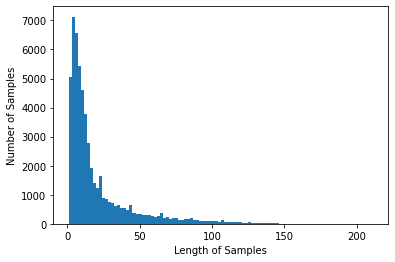

In [ ]:
plt.hist([len(s) for s in X_train], bins=100)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_length = 125
padding_type='post' #pre 데이터 앞을 0으로 post 데이터 뒤를 0으로

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다. 글씨 자르기
train_padded = pad_sequences(X_train, padding=padding_type, maxlen=max_length)
test_padded = pad_sequences(X_test, padding=padding_type, maxlen=max_length)
print(train_padded.shape)
print(test_padded.shape)

(54810, 125)
(19617, 125)


In [ ]:
print(train_padded.shape)
train_padded = train_padded.reshape(train_padded.shape[0],train_padded.shape[1],1)
test_padded = test_padded.reshape(test_padded.shape[0],test_padded.shape[1],1)
print(train_padded.shape)
print(test_padded.shape)

(54810, 125)
(54810, 125, 1)
(19617, 125, 1)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
X_train[:5]

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       'captain porch keeping carefully way treacherous shot intended turned spoke us doctors watch lookout dr odin take north side please jim east gray west watch hands load muskets lively men careful',
       'mercy gentlemen odin flung hands dont write anyway shame ive torn heart asunder seize opportunity fingering wounds halves oh god'],
      dtype='<U1433')

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    X_train, target_vocab_size=2**13)

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = 125

In [ ]:
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

TypeError: ignored

In [ ]:
MAX_LENGTH = 125

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN


    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')


  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, y_train)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
#print('답변 데이터의 크기(shape) :', answers.shape)

In [ ]:
print(len(answers[:-1]))
print(len(answers[1:]))
print(questions[1:].shape)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions[1:],
        'dec_inputs': answers[:-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

모델링

## 1

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf
from keras.layers import Attention, BatchNormalization
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Input
from keras.models import Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
embedding_dim = 64
sequence_input = Input(shape=(max_length, ))
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)

lstm = Bidirectional(LSTM(64, dropout=0.6, return_sequences = True))(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.6, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의, 64가
context_vector, attention_weights = attention(lstm, state_h)

dense1 = Dense(16, kernel_regularizer=l1(0.01), activation="relu")(context_vector) #과적합 방지를 위해 정규화
dense1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.6)(dense1) # 0.5 -> 0.8

output1 = Dense(5, activation="softmax")(dropout1)
model = Model(inputs=sequence_input, outputs=output1)

In [ ]:
#파라미터 설정

#oov_tok = "<OOV>"
#Tokenizer.fit_on_texts()  word_index 빈도가 높은 걸 인덱스가 낮게 표현하는 딕셔너리형태 {'것처럼': 1,}
#Tokenizer.fit_on_sequences() 원핫인코딩 컴퓨터 이해 x 사람이 이해

#모델 생성
#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#    tf.keras.layers.LSTM(64,activation='relu',return_sequences=True),
#    tf.keras.layers.LSTM(32,activation='relu',return_sequences=True),
#    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(5, activation='softmax')
#])

#과대적합이 일어나므로 모델을 키우고
# compile model
model.compile(loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy
              optimizer='adam',
              metrics=['accuracy'])
#얼리스탑핑 체크포인트 베스트모델 트랜스포머 어텐션ㄱ계여ㅑㄹ lstm 어텐션계열~?
# model summary
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 125, 64)      1270272     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 125, 128)     66048       embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 125, 128), ( 98816       bidirectional_2[0][0]            
_______________________________________________________________________________________

In [ ]:
# fit model
start = time.time()
check_point_cb = ModelCheckpoint('/content/drive/My Drive/Writing_Style/Writer_style.h5', save_best_only=True, save_weights_only=True)
early_stopping_cb = EarlyStopping(patience=5, monitor='val_loss',
                                  restore_best_weights=True,)
num_epochs = 60
history = model.fit(x=train_padded,
                    y=y_train, 
                    callbacks=[check_point_cb,early_stopping_cb],#check_point_cb,
                    epochs=num_epochs, verbose=1, #verbose 출력되는 인자 0 노출력 1 진행막대 2 미니배치마다 손실정보출력
                    validation_split=0.2) 
end = time.time() 
print('Time: {}'.format(end-start))
#드랍아웃 0.6 유닛수 128 save_weigthsonly = True

Epoch 1/60
1371/1371 [==============================] - 438s 319ms/step - loss: 1.4472 - accuracy: 0.4532 - val_loss: 0.9839 - val_accuracy: 0.6169
Epoch 2/60
1371/1371 [==============================] - 440s 321ms/step - loss: 1.0400 - accuracy: 0.5809 - val_loss: 0.8852 - val_accuracy: 0.6533
Epoch 3/60
1371/1371 [==============================] - 435s 317ms/step - loss: 0.9601 - accuracy: 0.6121 - val_loss: 0.8792 - val_accuracy: 0.6507
Epoch 4/60
1371/1371 [==============================] - 439s 320ms/step - loss: 0.9084 - accuracy: 0.6351 - val_loss: 0.8857 - val_accuracy: 0.6665
Epoch 5/60
1371/1371 [==============================] - 434s 317ms/step - loss: 0.8775 - accuracy: 0.6478 - val_loss: 0.9101 - val_accuracy: 0.6627
Epoch 6/60
1371/1371 [==============================] - 441s 322ms/step - loss: 0.8466 - accuracy: 0.6688 - val_loss: 0.8786 - val_accuracy: 0.7029
Epoch 7/60
1371/1371 [==============================] - 435s 317ms/step - loss: 0.8120 - accuracy: 0.6947 - val_

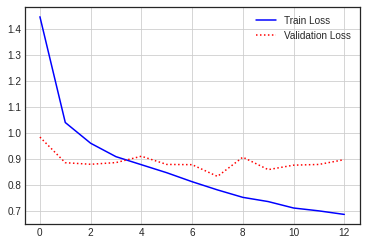

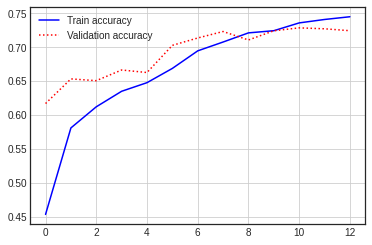

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

hist_dict = history.history
hist_dict.keys()

plt.plot(hist_dict['loss'], 'b-', label='Train Loss')
plt.plot(hist_dict['val_loss'], 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(hist_dict['accuracy'], 'b-', label='Train accuracy')
plt.plot(hist_dict['val_accuracy'], 'r:', label='Validation accuracy')
plt.legend()
plt.grid()
#relu 과적합이 더 심하게 일어남
#dropout 0.5적용 하니 성능 상승

In [ ]:
# predict values ,predict_proba 
pred = model.predict(test_padded)

In [ ]:
pred #작가의 수가 5명이라서 5개로 나옴

array([[2.8574938e-02, 2.6296407e-01, 5.6755394e-01, 4.4736311e-02,
        9.6170790e-02],
       [7.2234452e-02, 3.3062497e-01, 3.3202708e-01, 1.6093387e-01,
        1.0417962e-01],
       [9.9410665e-01, 2.3600676e-03, 1.2405356e-03, 1.3487209e-03,
        9.4398652e-04],
       ...,
       [7.4535020e-04, 9.9866617e-01, 4.0107770e-04, 1.6888684e-04,
        1.8415962e-05],
       [7.5320248e-04, 9.9867380e-01, 3.9794587e-04, 1.5716677e-04,
        1.7824101e-05],
       [9.9212414e-01, 1.9620110e-03, 2.1572998e-03, 1.9410974e-03,
        1.8155442e-03]], dtype=float32)

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission
#

,index,0,1,2,3,4
0,0,0.028575,0.262964,0.567554,0.044736,0.096171
1,1,0.072234,0.330625,0.332027,0.160934,0.104180
2,2,0.994107,0.002360,0.001241,0.001349,0.000944
3,3,0.007413,0.000831,0.384761,0.003048,0.603946
4,4,0.984336,0.004817,0.003887,0.004735,0.002225
...,...,...,...,...,...,...
19612,19612,0.000977,0.998351,0.000468,0.000182,0.000022
19613,19613,0.003096,0.000019,0.056797,0.000100,0.939989
19614,19614,0.000745,0.998666,0.000401,0.000169,0.000018
19615,19615,0.000753,0.998674,0.000398,0.000157,0.000018


In [ ]:
sample_submission.to_csv('submission.csv', index = False, encoding = 'utf-8')

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2

###0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 1

In [ ]:
import torch

(1, 19848, 128)
(1, 19848, 128)


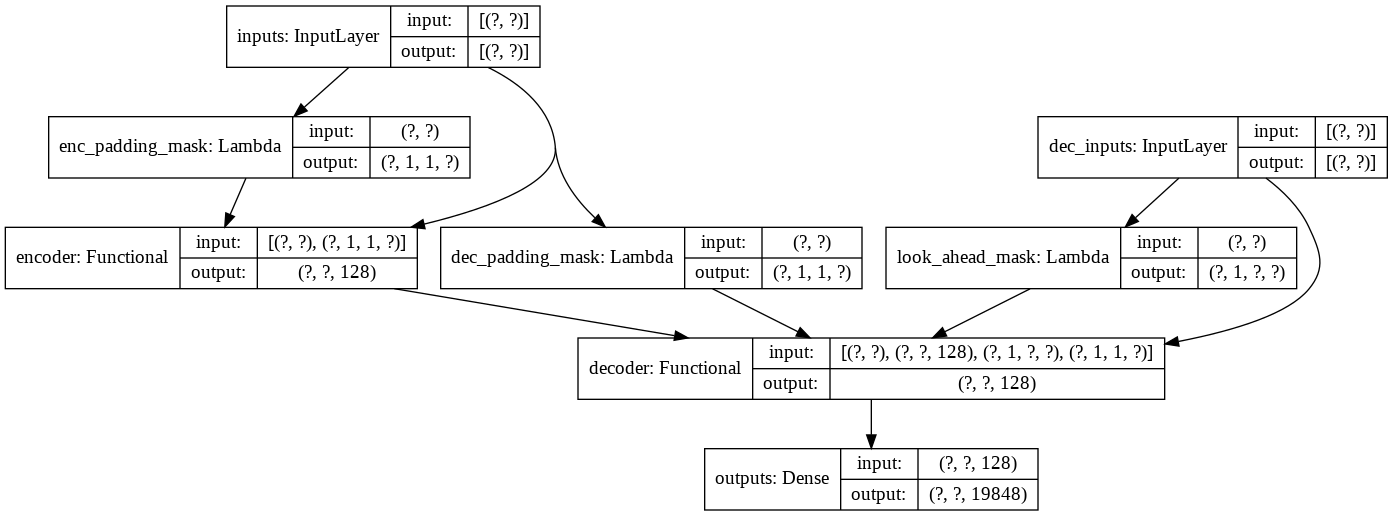

In [ ]:
small_transformer = transformer(
    vocab_size = vocab_size,
    num_layers = 2,
    dff = 512,
    d_model = 128,
    num_heads = 8,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
D_MODEL = 128
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

small_transformer.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
#questions, answers  = x_train, y_train 

In [ ]:
EPOCHS = 50
small_transformer.fit(dataset, epochs=EPOCHS)

Epoch 1/50


InvalidArgumentError: ignored

## 3

###0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import torch

In [ ]:
train_padded =  train_padded.reshape(54810,125)
#train_padded

In [ ]:
padded = torch.from_numpy(train_padded)
padded = torch.tensor(padded).to(torch.int64)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(vocab_size, d_hidn) # embedding 객체

input_embs = nn_emb(padded) # input embedding
print(input_embs.size())

torch.Size([54810, 125, 128])


In [ ]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(128, 128)


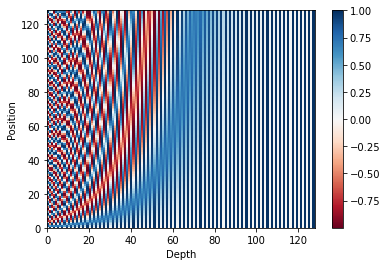

In [ ]:
n_seq = 128
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
inputs = padded

In [ ]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

#print(inputs)
#print(positions)
#print(pos_embs.size())

In [ ]:
input_sums = input_embs + pos_embs

In [ ]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
#print(attn_mask.size())
#print(attn_mask[0])

###1

In [ ]:
""" ScaledDotProductAttention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

In [ ]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

In [ ]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

In [ ]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

In [ ]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

In [ ]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [ ]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [ ]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

### 2

In [ ]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [ ]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [ ]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [ ]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "<path of data>/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "<path of data>/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

In [ ]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [ ]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [ ]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 5
print(config)

learning_rate = 5e-5
n_epoch = 10

In [ ]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

In [ ]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()